# Democratic Caucus General Market Activity

This notebook creates Figures 2 and 3 and Table 1.

In [1]:
import os
import sys
import re

from itertools import *
from operator import mul
from functools import reduce
import pickle

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

idx = pd.IndexSlice

from research_tools import storage

pd.options.display.float_format = lambda x: '{:,.4f}'.format(x) if abs(x) < 1 else '{:,.2f}'.format(x)

# Load Data

In [2]:
os.chdir('..')

basename = 'dem'

orders, behavior_analysis, trader_analysis, quotes_dict = storage.retrieve_all(
    [basename + '.orders',
     basename + '.behavior_analysis',
     basename + '.trader_analysis',
     basename + '.reconstructed_quotes'])

Reading data from data/dem.orders.p
Reading data from data/dem.behavior_analysis.p
Reading data from data/dem.trader_analysis.p
Reading data from data/dem.reconstructed_quotes.p


# Plot Prices

This chart is for Figure 3.

In [3]:
quotes_dict.keys()

dict_keys([840, 841, 842, 843, 844, 845])

In [4]:
contract_names = {840: 'Hillary Clinton',
                  841: 'Bernie Sanders',
                  842: 'Joe Biden',
                  843: "Martin O'Malley",
                  844: 'Jim Webb',
                  845: 'Lincoln Chafee'}

contract_names2 = {840: 'Clinton',
                   841: 'Sanders',
                   842: 'Biden',
                   843: "O'Malley",
                   844: 'Webb',
                   845: 'Chafee'}

In [5]:
def plot_prices(xlim=None, contracts=None, title=None):
    if not contracts:
        contracts = quotes_dict.keys()

    n = len(contracts)
    fig = plt.figure(figsize=(7.5, 1.875 * n))

    if title:
        plt.suptitle(title)
    
    for i, c_id in enumerate(contracts):
        df = quotes_dict[c_id]
        df['mid price'] = df[['bid_price', 'ask_price']].mean(axis=1)

        ax = plt.subplot(n, 1, i + 1)
        df.plot(x='timestamp', y='mid price', ax=ax, c='black', sharex=ax, label=c_id)
        plt.ylim([0, 1])
        plt.grid(True)
        plt.legend([contract_names2[c_id] + ' price'])
        
        if xlim:
            plt.xlim([pd.Timestamp(xlim), pd.Timestamp('2016.02.02 14:00', tz='US/Eastern')])        

    plt.xlabel('Date')
    
    plt.tight_layout()

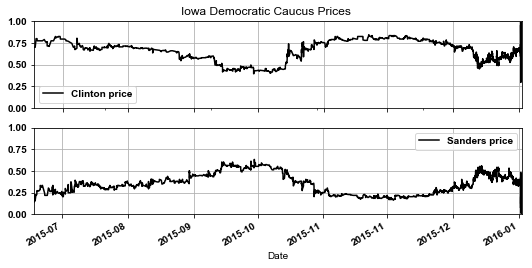

In [6]:
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 10}

mpl.rc('font', **font)

plot_prices(contracts=[840, 841], title='Iowa Democratic Caucus Prices')

plt.tight_layout(rect=(0, 0, 1, 0.98))

plt.savefig('charts/dem_caucus_prices.png', dpi=300)

In [7]:
trader_analysis['day_of_trade'] = trader_analysis.date_executed.dt.date

daily_activity = trader_analysis.groupby('day_of_trade')[['quantity', 'notional']].sum()
daily_activity.index = pd.to_datetime(daily_activity.index)
daily_activity2 = daily_activity['2016-01-01':]

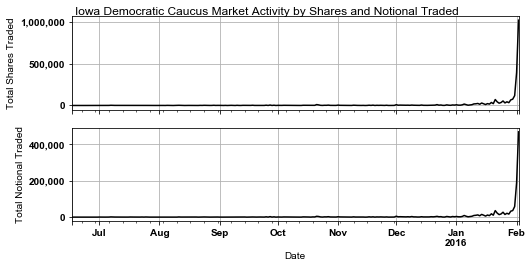

In [8]:
plt.figure(figsize=(7.5, 3.75))

plt.suptitle('Iowa Democratic Caucus Market Activity by Shares and Notional Traded')

ax1 = plt.subplot(2, 1, 1)
daily_activity['quantity'].plot(c='k', ax=ax1, label='Shares Traded')
plt.xlabel('Date')
plt.ylabel('Total Shares Traded')
ax1.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.grid(True)

ax2 = plt.subplot(2, 1, 2)
daily_activity['notional'].plot(c='k', ax=ax2, label='Shares Traded', sharex=ax1)
plt.xlabel('Date')
plt.ylabel('Total Notional Traded')
ax2.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.grid(True)

plt.tight_layout()

# Per-contract Volume Activity

This shows the popular contracts. It is Table 1 in the paper.

In [9]:
out = trader_analysis.groupby('contract_id')[['quantity', 'notional']].sum()
out.index = [contract_names2[x] for x in out.index]

print(out.to_latex())
out

\begin{tabular}{lrr}
\toprule
{} &  quantity &   notional \\
\midrule
Clinton  &   1223458 & 568,022.08 \\
Sanders  &   1327990 & 659,721.16 \\
Biden    &     41566 &  18,150.80 \\
O'Malley &     44048 &  23,622.64 \\
Webb     &      5328 &   2,288.70 \\
Chafee   &         8 &       5.96 \\
\bottomrule
\end{tabular}



,quantity,notional
Clinton,1223458,"568,022.08"
Sanders,1327990,"659,721.16"
Biden,41566,"18,150.80"
O'Malley,44048,"23,622.64"
Webb,5328,"2,288.70"
Chafee,8,5.96


Total market activity and fees

In [10]:
trader_analysis[['quantity', 'notional', 'fee']].sum()

quantity   2,642,398.00
notional   1,271,811.34
fee           11,718.86
dtype: float64

By-trader metrics

In [11]:
trader_analysis.groupby('user_guid')[['quantity', 'notional', 'gross_pnl', 'fee', 'pnl_net_fee']].sum().describe()

,quantity,notional,gross_pnl,fee,pnl_net_fee
count,"3,750.00","3,750.00","3,750.00","3,750.00","3,750.00"
mean,704.64,339.15,-0.0000,3.13,-3.13
std,"3,007.47","1,344.40",168.75,11.66,162.18
min,2.00,0.0100,"-1,699.58",0.0000,"-1,699.58"
25%,20.00,8.66,-9.00,0.0000,-9.20
50%,80.00,30.34,-0.1100,0.0700,-0.1950
75%,317.50,137.93,7.26,0.9750,6.31
max,"92,932.00","43,985.50","1,319.49",131.95,"1,187.54"


By-trader metrics

In [12]:
behavior_analysis[['max_loss', 'max_in_pool', 'pnl']].describe()

,max_loss,max_in_pool,pnl
count,"3,750.00","3,750.00","3,750.00"
mean,111.13,111.27,-3.13
std,277.68,283.93,162.18
min,0.0100,0.0100,"-1,699.58"
25%,5.18,5.12,-9.20
50%,16.50,16.49,-0.1950
75%,63.00,62.67,6.31
max,"1,700.00","2,757.80","1,187.54"


Total amount of capital risked by traders

In [13]:
behavior_analysis[['max_loss', 'max_in_pool']].sum()

max_loss      416,727.65
max_in_pool   417,251.70
dtype: float64

# Sum of midquotes charts

This chart is Figure 2.

In [14]:
def make_interval_quotes(df):
    df = df.set_index('timestamp')

    start = df.index[0].floor('1Min')
    end = df.index[-1].floor('1Min')

    timestamp_intervals = pd.date_range(start, end, freq='1Min')

    return df[['bid_price', 'ask_price']].apply(lambda x: x.asof(timestamp_intervals)).bfill()

def make_quote_panel(quotes):
    quotes_intervals = {c_id: make_interval_quotes(df) for c_id, df in quotes.items()}

    start = min([df.index[0] for df in quotes_intervals.values()])
    end = max([df.index[-1] for df in quotes_intervals.values()])
    timestamp_intervals = pd.date_range(start, end, freq='1Min')

    panel = Panel({c_id: df.loc[timestamp_intervals].ffill() for c_id, df in quotes_intervals.items()})
    
    return panel

In [15]:
quote_panel = make_quote_panel(quotes_dict)

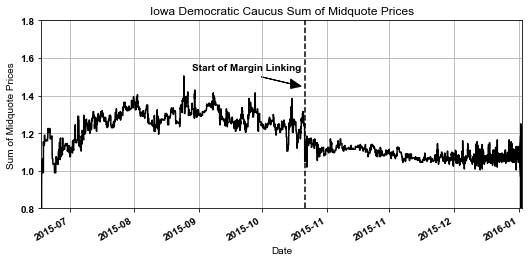

In [16]:
plt.figure(figsize=(7.5, 3.75))

ax1 = plt.gca()

quote_panel.mean(axis=2).sum(axis=1).plot(c='k', ax=ax1)
plt.title('Iowa Democratic Caucus Sum of Midquote Prices')
plt.ylim([0.8, 1.8])
plt.vlines(x=[pd.Timestamp('2015-10-22')], ymin=0.8, ymax=1.8, linestyles='dashed')
plt.text(pd.Timestamp('2015-10-20'), 1.55, 'Start of Margin Linking',
         horizontalalignment='right', verticalalignment='center')
plt.arrow(x=pd.Timestamp('2015-10-01'), y=1.5, dx=19, dy=-0.05,
          length_includes_head=True, head_width=0.05, head_length=5, color='k')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Sum of Midquote Prices')

plt.tight_layout()

plt.savefig('charts/dem_sum_midquotes.png', dpi=300)